In [1]:
push!(LOAD_PATH, "..")
using ASE
using MatSciPy
using PyPlot
using PyCall
using TightBinding

### Test band structure of Carbon

64

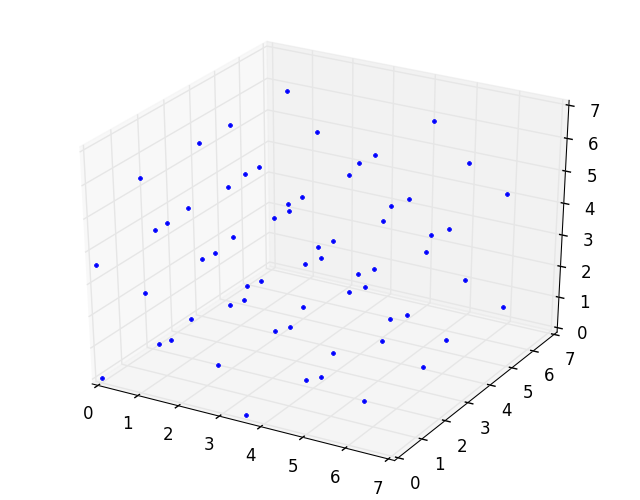

In [37]:
at = bulk("C"; cubic=true)
at = repeat(at, (2, 2, 2))
X = positions(at)
# set_pbc!(at, [false, false, false])
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
print(length(at))

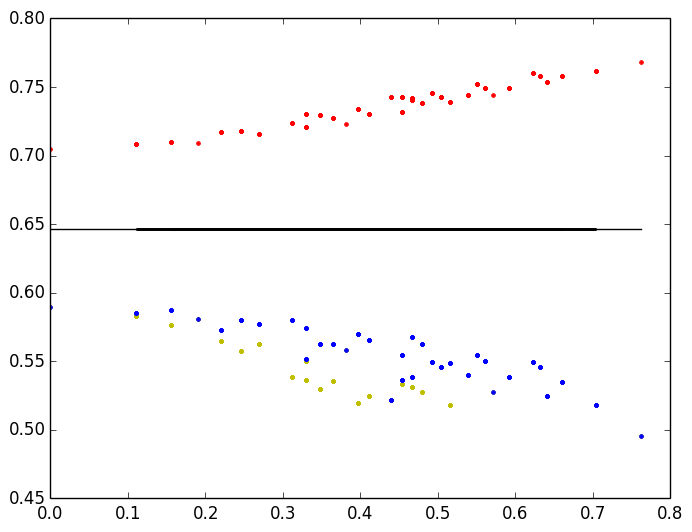

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x54a5350>

In [22]:
import NRLTB
reload("TightBinding")
reload("NRLTB")
tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)

set_pbc!(at, [true, true, true])
tbm.nkpoints = (8,8,8)

K, E = TightBinding.band_structure(at, tbm)

# take a very low temperature to approximate the fermi level at 0 temperature
tbm.fixed_eF = false
tbm.smearing.beta = 1000
TightBinding.update_eF!(at, tbm)
EF = tbm.eF

n = size(K,2)
kk = zeros(n)
for k = 1:n
    kk[k] = norm(K[:,k])
end

plot(kk, E[1,:][:], "y.")
hold
plot(kk, E[2,:][:], "b.")
plot(kk, E[3,:][:], "r.")
plot(kk, ones(n)*EF, "k-" )

In [29]:
# remove an atom at center

X = positions(at)
# 64 atoms in total, the 57th atom is at center
#print(X[:,58])
Y = zeros(3,63)
Y = X[:,1:63]
#Y[:,1:56] = X[:,1:56]
#Y[:,57:63] = X[:,58:64]

# from ase import Atoms
# using PyCall
# @pyimport ase
# at_vac = ASEAtoms( ase.Atoms(symbols = "C63", positions = Y, cell = cell(at), pbc = [true, true, true]) )

3x63 Array{Float64,2}:
 0.0  0.8925  0.0    0.8925  1.785  …  3.57   4.4625  5.355  6.2475  5.355
 0.0  0.8925  1.785  2.6775  0.0       5.355  6.2475  3.57   4.4625  5.355
 0.0  0.8925  1.785  2.6775  1.785     5.355  6.2475  5.355  6.2475  3.57 

63

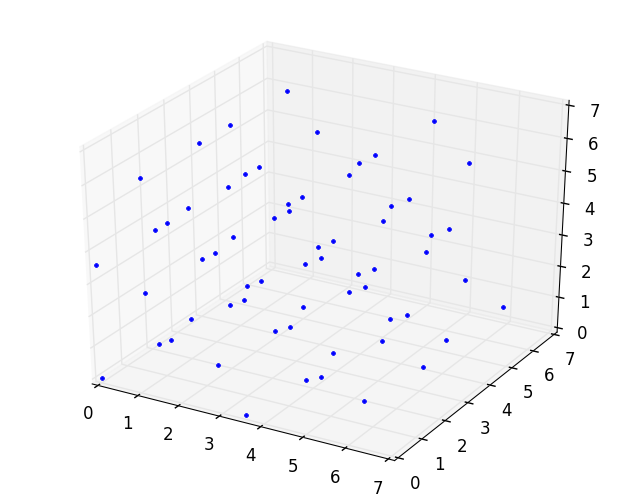

In [30]:
using PyCall
@pyimport ase

#at_vac = ase.Atoms()
at_vac = ASEAtoms( ase.Atoms("C63") )
set_cell!(at_vac, cell(at))
set_positions!(at_vac, Y)
set_pbc!(at_vac, [true, true, true])

X_vac = positions(at_vac)
plot3D(X_vac[1,:][:], X_vac[2,:][:], X_vac[3,:][:], "b.")
print(length(at_vac))

0.5839833352903583

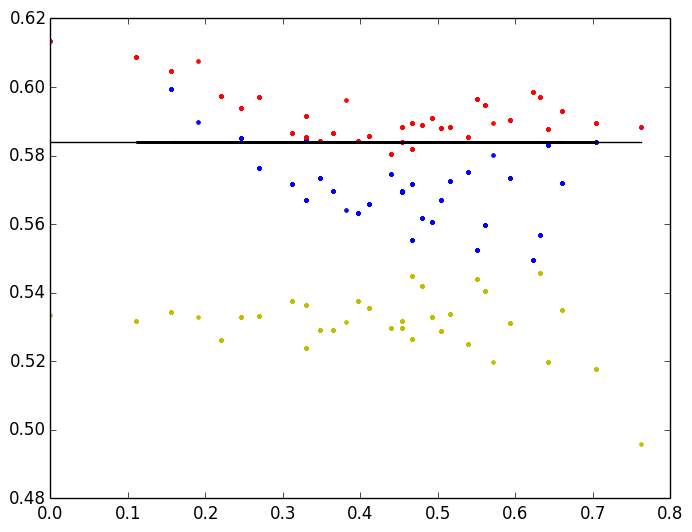

In [31]:
import NRLTB
reload("TightBinding")
reload("NRLTB")
tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)

set_pbc!(at_vac, [true, true, true])
tbm.nkpoints = (8,8,8)

K, E = TightBinding.band_structure(at_vac, tbm)

# take a very low temperature to approximate the fermi level at 0 temperature
tbm.fixed_eF = false
tbm.smearing.beta = 1000
TightBinding.update_eF!(at_vac, tbm)
EF = tbm.eF

n = size(K,2)
kk = zeros(n)
for k = 1:n
    kk[k] = norm(K[:,k])
end

plot(kk, E[1,:][:], "y.")
hold
plot(kk, E[2,:][:], "b.")
plot(kk, E[3,:][:], "r.")
plot(kk, ones(n)*EF, "k-" )

print(EF)

### Test toy TB model for Al

In [2]:
at = bulk("Al")#; cubic=true)
at = repeat(at, (2, 2, 1))
X = positions(at)
# set_pbc!(at, [false, false, false])
# plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
print(length(at))

4

In [3]:
# reload("Potentials")
# reload("tbtoymodel")
# reload("TightBinding")
# reload("MatSciPy")
tbm = TightBinding.ToyTB.ToyTBModel(r0=2.5, rcut=6.0)
E = TightBinding.potential_energy(at, tbm)
println("E = ", E)
frc = TightBinding.forces(at, tbm)
println("|f|∞ = ", norm(frc[:], Inf))

E = -15.758671486710963
|f|∞ = 4.40619762898109e-16


In [7]:
set_pbc!(at, [false, false, false])

reload("TightBinding")
tbm = TightBinding.ToyTB.ToyTBModel(r0=2.5, rcut=6.0)
E = TightBinding.potential_energy(at, tbm)
println("E = ", E)
frc = TightBinding.forces(at, tbm)
println("|f|∞ = ", norm(frc[:], Inf))

E = -

2.2402263145143673
|f|∞ = 0.14601367064044007


In [5]:
reload("Potentials")
reload("TightBinding")
reload("tbtoymodel")

set_pbc!(at, [false, false, false])
#set_pbc!(at, [true, true, true])

tbm = TightBinding.ToyTB.ToyTBModel(r0=2.5, rcut=8.0)
X = positions(at)
f = TightBinding.potential_energy(at, tbm)
df = TightBinding.forces(at, tbm)[:]
    println("-----------------------------")
    println("  p | error ")
    println("----|------------------------")
    for p = 2:12
        h = 0.1^p
        dfh = zeros(length(df))
        for n = 1:length(df)
            X[n] += h
            set_positions!(at, X)
            dfh[n] = (TightBinding.potential_energy(at, tbm) - f) / h
            X[n] -= h
        end
    #@printf(" %2d | %1.7e \n", p, norm(df - dfh, Inf))
    @printf(" %2d | %1.7e \n", p, norm(dfh + df, Inf))
    end
println("-----------------------------")


-----------------------------
  p | error 
----|------------------------
  2 | 1.4867346e-03 
  3 | 1.4867270e-04 
  4 | 1.4867263e-05 
  5 | 1.4865886e-06 
  6 | 1.5010215e-07 
  7 | 2.4461734e-08 
  8 | 3.1718760e-07 
  9 | 3.1797765e-06 
 10 | 3.8596093e-05 
 11 | 3.8683979e-04 
 12 | 3.9968029e-03 
-----------------------------


### Test NRL-TB model for Al

In [7]:
# TEST the NRL-TB hamiltonian constructor
import NRLTB
reload("NRLTB")
a = rand(3)*6

f = NRLTB.mat_local(norm(a), a, NRLTB.Al_spd, "H")
df = NRLTB.d_mat_local(norm(a), a, NRLTB.Al_spd, "dH")
println("-----------------------------")
println("  p | error ")
println("----|------------------------")
for p = 2:12
    h = 0.1^p
    dfh = zeros(size(df))
    for n = 1:3
        a[n] += h
        fh = NRLTB.mat_local(norm(a), a, NRLTB.Al_spd, "H")
        dfh[n,:] = (fh - f) / h
        a[n] -= h
    end
    err = reshape(dfh - df, 3*81)
    @printf(" %2d | %1.7e \n", p, norm(err,Inf))
end
println("-----------------------------")

-----------------------------
  p | error 
----|------------------------
  2 | 4.7936432e-04 
  3 | 4.8252387e-05 
  4 | 4.8284068e-06 
  5 | 4.8288380e-07 
  6 | 4.8356390e-08 
  7 | 4.7385025e-09 
  8 | 1.5400929e-08 
  9 | 1.1461380e-07 
 10 | 1.1590824e-06 
 11 | 9.4107278e-06 
 12 | 1.6019853e-04 
-----------------------------


In [21]:
# TEST NRL-TB for Aluminum FCC

reload("SparseTools")
reload("Potentials")
reload("TightBinding")
reload("NRLTB")    
BOHR = 0.52917721092 

set_pbc!(at, [false, false, false])
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)

X = positions(at)
f = TightBinding.potential_energy(at, tbm)
df = TightBinding.forces(at, tbm)[:] # / BOHR
    println("-----------------------------")
    println("  p | error ")
    println("----|------------------------")
for p = 2:12
    h = 0.1^p 
    dfh = zeros(length(df))
    for n = 1:length(df)
        X[n] += h
        set_positions!(at, X)
        dfh[n] = (TightBinding.potential_energy(at, tbm) - f) / h
        X[n] -= h
    end
    @printf(" %2d | %1.7e \n", p, norm(dfh + df, Inf))
end
println("-----------------------------")

-----------------------------
  p | error 
----|------------------------
  2 | 5.0889126e-03 
  3 | 5.0887465e-04 
  4 | 5.0887431e-05 
  5 | 5.0888439e-06 
  6 | 5.0871044e-07 
  7 | 3.8906909e-08 
  8 | 1.4159240e-07 
  9 | 1.6771453e-06 
 10 | 1.8326597e-05 
 11 | 1.3877791e-04 
 12 | 2.2139949e-03 
-----------------------------


In [73]:
# TEST NRL-TB for Aluminum FCC
# WITH PERIODIC BOUNDARY CONDITION ON THIRD DIMENSION
# TAKE nkpoints = (0,0,4)

reload("SparseTools")
reload("Potentials")
reload("TightBinding")
reload("NRLTB")    
BOHR = 0.52917721092 

set_pbc!(at, [false, false, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
tbm.nkpoints = (2,2,0)


X = positions(at)
f = TightBinding.potential_energy(at, tbm)
df = TightBinding.forces(at, tbm)[:] # / BOHR
    println("-----------------------------")
    println("  p | error ")
    println("----|------------------------")
for p = 2:10
    h = 0.1^p 
    dfh = zeros(length(df))
    for n = 1:length(df)
        X[n] += h
        set_positions!(at, X)
        dfh[n] = (TightBinding.potential_energy(at, tbm) - f) / h
        X[n] -= h
    end
    @printf(" %2d | %1.7e \n", p, norm(dfh + df, Inf))
end
println("-----------------------------")

-----------------------------
  p | error 
----|------------------------
  2 | 1.6308510e-03 
  3 | 1.6310346e-04 
  4 | 1.6310438e-05 
  5 | 1.6310517e-06 
  6 | 1.6804419e-07 
  7 | 1.1760060e-07 
  8 | 1.1113269e-06 
  9 | 1.0949365e-05 
 10 | 9.3632306e-05 
-----------------------------


## TEST site energy and site force

In [3]:
# TEST NRL-TB site energy for Aluminum FCC
# WITH open BOUNDARY CONDITION ON THIRD DIMENSION

using AtomsInterface
reload("SparseTools")
reload("Potentials")
reload("TightBinding")
reload("NRLTB")  

set_pbc!(at, [false, false, false])
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
tbm.nkpoints = (0,0,0)

X = positions(at)

Es_all = TightBinding.site_energy([1:length(at);], at, tbm)
Etot = TightBinding.potential_energy(at, tbm)
println("E - ∑ E_i = ", Etot - r_sum(Es_all))
println("------------------------------")

println("Finite-difference test")
Es = TightBinding.site_energy(1, at, tbm)
Fs = TightBinding.site_forces(1, at, tbm)[:]

println("-----------------------------")
println("  p | error ")
println("----|------------------------")
for p = 2:12
    h = 0.1^p 
    dEsh = zeros(length(Fs))
    for n = 1:length(Fs)
        X[n] += h
        set_positions!(at, X)
        dEsh[n] = (TightBinding.site_energy(1, at, tbm) - Es) / h
        X[n] -= h
    end
    @printf(" %2d | %1.7e \n", p, norm(dEsh + Fs, Inf))
end
println("-----------------------------")

E - ∑ E_i = 1.7763568394002505e-15
------------------------------
Finite-difference test
-----------------------------
  p | error 
----|------------------------
  2 | 1.8566967e-04 
  3 | 1.8596652e-05 
  4 | 1.8599778e-06 
  5 | 1.8603239e-07 
  6 | 2.0431525e-08 
  7 | 2.7374072e-08 
  8 | 3.2581899e-07 
  9 | 1.3966640e-06 
 10 | 1.6372396e-05 
 11 | 1.7062366e-04 
 12 | 1.6298718e-03 
-----------------------------


In [3]:
# TEST NRL-TB site energy for Aluminum FCC
# WITH periodic BOUNDARY CONDITION ON THIRD DIMENSION

using AtomsInterface
reload("SparseTools")
reload("Potentials")
reload("TightBinding")
reload("NRLTB")  

set_pbc!(at, [false, false, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
tbm.nkpoints = (0,0,0)

X = positions(at)

Es_all = TightBinding.site_energy([1:length(at);], at, tbm)
Etot = TightBinding.potential_energy(at, tbm)
println("E - ∑ E_i = ", Etot - r_sum(Es_all))
println("------------------------------")

println("Finite-difference test")
Es = TightBinding.site_energy(1, at, tbm)
Fs = TightBinding.site_forces(1, at, tbm)[:]

println("-----------------------------")
println("  p | error ")
println("----|------------------------")
for p = 2:12
    h = 0.1^p 
    dEsh = zeros(length(Fs))
    for n = 1:length(Fs)
        X[n] += h
        set_positions!(at, X)
        dEsh[n] = (TightBinding.site_energy(1, at, tbm) - Es) / h
        X[n] -= h
    end
    @printf(" %2d | %1.7e \n", p, norm(dEsh + Fs, Inf))
end
println("-----------------------------")

E - ∑ E_i = -1.7763568394002505e-15
------------------------------
Finite-difference test
-----------------------------
  p | error 
----|------------------------
  2 | 4.0478141e-04 
  3 | 4.0374202e-05 
  4 | 4.0363689e-06 
  5 | 4.0347931e-07 
  6 | 4.1744386e-08 
  7 | 3.1675312e-08 
  8 | 2.0657823e-07 
  9 | 1.7763568e-06 
 10 | 1.7598920e-05 
 11 | 2.7367671e-04 
 12 | 1.7763568e-03 
-----------------------------


### performance 

In [24]:
reload("SparseTools")
reload("Potentials")
reload("TightBinding")
reload("NRLTB")    

at = bulk("Al"; cubic=true)
at = repeat(at, (2, 2, 2))
set_pbc!(at, [true, true, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
tbm.nkpoints = (0,0,2)

@time df = TightBinding.forces(at, tbm)[:];
@time df = TightBinding.forces_(at, tbm)[:];
@time df = TightBinding.forces(at, tbm)[:];
@time df = TightBinding.forces_(at, tbm)[:];

ctr = 331776
  3.715835 seconds (9.36 M allocations: 1.757 GB, 8.19% gc time)
ctr = 17978112
 15.347712 seconds (111.72 M allocations: 2.286 GB, 3.60% gc time)
ctr = 331776
  1.342842 seconds (5.29 M allocations: 1.259 GB, 16.70% gc time)
ctr = 17978112
 15.253434 seconds (111.57 M allocations: 2.280 GB, 3.55% gc time)


# Performance Tests (CO)

In [1]:
push!(LOAD_PATH, "..")
using ASE, TestAtoms
import TightBinding
import NRLTB
import ProfileView, Base.Profile

In [3]:
at = bulk("Al"; cubic=true)
at = repeat(at, (2, 2, 1))
set_pbc!(at, [false, false, true])
X = positions(at)
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
# tbm = TightBinding.ToyTB.ToyTBModel()
tbm.nkpoints = (0,0,0)
TestAtoms.test_potentialenergy(tbm, at)
set_positions!(at, X+0.1*rand(size(X)))
@time E = TightBinding.potential_energy(at, tbm)
set_positions!(at, X+0.1*rand(size(X)))
@time E = TightBinding.potential_energy(at, tbm)
set_positions!(at, X+0.1*rand(size(X)))
@time E = TightBinding.potential_energy(at, tbm)
set_positions!(at, X+0.1*rand(size(X)))
@time E = TightBinding.potential_energy(at, tbm)

@time df = TightBinding.forces(at, tbm);
@time df = TightBinding.forces(at, tbm);
@time df = TightBinding.forces(at, tbm);
@time df = TightBinding.forces(at, tbm);

# TightBinding.forces_debug(at, tbm)
;

-----------------------------
  p | error 
----|------------------------
  2 | 1.6082659e-03 
  3 | 1.6084285e-04 
  4 | 1.6084343e-05 
  5 | 1.6093793e-06 
  6 | 1.7053026e-07 
  7 | 1.4210855e-07 
  8 | 1.4210855e-06 
  9 | 9.0469449e-06 
 10 | 1.1677271e-04 
-----------------------------
  0.035420 seconds (49.74 k allocations: 21.602 MB, 6.34% gc time)
  0.039333 seconds (49.51 k allocations: 21.567 MB, 11.82% gc time)
  0.037315 seconds (49.51 k allocations: 21.567 MB, 6.98% gc time)
  0.037895 seconds (49.46 k allocations: 21.556 MB, 6.05% gc time)
  0.046265 seconds (138.00 k allocations: 35.888 MB, 13.48% gc time)
  0.035591 seconds (138.00 k allocations: 35.888 MB, 5.70% gc time)
  0.040717 seconds (138.00 k allocations: 35.888 MB, 10.11% gc time)
  0.038626 seconds (138.00 k allocations: 35.888 MB, 10.85% gc time)


In [13]:
@code_warntype TightBinding.hamiltonian(at, tbm, rand(3))

In [3]:


at = bulk("Al"; cubic=true)
at = repeat(at, (4, 4, 1))
X = positions(at)
set_pbc!(at, [false, false, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.Al_spd)
# tbm = TightBinding.ToyTB.ToyTBModel()
tbm.nkpoints = (0,0,4)

Profile.clear()
@profile f = TightBinding.potential_energy(at, tbm);
set_positions!(at, X+0.1*rand(size(X)))
@profile f = TightBinding.potential_energy(at, tbm);


In [ ]:
ProfileView.view()

### Test ForwardDiff for dH, d2H, and d3H

In [84]:
a = rand(3)/2

3-element Array{Float64,1}:
 0.0475555
 0.1646   
 0.428756 

In [86]:
# TEST the ForwardDiff for NRL-TB hamiltonian derivatives
import NRLTB
reload("NRLTB")
BOHR = 0.52917721092 

h = zeros(4,4)
f = zeros(4,4)
dh = zeros(3,4,4)
# f = NRLTB.mat_local_h!(norm(a)/BOHR, a/BOHR, NRLTB.C_sp, h, zeros(4))
NRLTB.mat_local_h!(norm(a)/BOHR, a/BOHR, NRLTB.C_sp, h, zeros(4))
f[:] = h[:]
df = NRLTB.mat_local_dh!(a/BOHR, NRLTB.C_sp, dh)
println("-----------------------------")
println("  p | error ")
println("----|------------------------")
for p = 2:12
    δ = 0.1^p
    dfh = zeros(size(df))
    for n = 1:3
        a[n] += δ
        fh = NRLTB.mat_local_h!(norm(a)/BOHR, a/BOHR, NRLTB.C_sp, h, zeros(4))
        # print(fh-f) println("\n")
        dfh[n,:] = ( (fh - f) / δ ) * BOHR
        a[n] -= δ
    end
    err = reshape( dfh - df, 3*4*4)
    @printf(" %2d | %1.7e \n", p, norm(err, Inf))
end
println("-----------------------------")

-----------------------------
  p | error 
----|------------------------
  2 | 4.2989462e-01 
  3 | 4.3327567e-02 
  4 | 4.3361221e-03 
  5 | 4.3364589e-04 
  6 | 4.3365937e-05 
  7 | 4.3462234e-06 
  8 | 3.9819165e-07 
  9 | 1.7165526e-06 
 10 | 1.9341967e-05 
 11 | 1.5341950e-04 
 12 | 1.4694301e-03 
-----------------------------


In [93]:
@time NRLTB.d_mat_local(norm(a)/BOHR, a/BOHR, NRLTB.C_sp, :dH)
@time NRLTB.mat_local_dh!(a/BOHR, NRLTB.C_sp, dh)
@time NRLTB.d_mat_local(norm(a)/BOHR, a/BOHR, NRLTB.C_sp, :dH)
@time NRLTB.mat_local_dh!(a/BOHR, NRLTB.C_sp, dh)
@time NRLTB.d_mat_local(norm(a)/BOHR, a/BOHR, NRLTB.C_sp, :dH)
@time NRLTB.mat_local_dh!(a/BOHR, NRLTB.C_sp, dh)
a

3-element Array{Float64,1}:
 0.0475555
 0.1646   
 0.428756 

0.000011 seconds (28 allocations: 1.656 KB)
  0.000585 seconds (3.33 k allocations: 149.031 KB)
  0.000008 seconds (28 allocations: 1.656 KB)
  0.000502 seconds (3.33 k allocations: 149.031 KB)
  0.000005 seconds (28 allocations: 1.656 KB)
  0.000476 seconds (3.33 k allocations: 149.031 KB)


In [91]:
c = NRLTB.d_mat_local(norm(a)/BOHR, a/BOHR, NRLTB.C_sp, :dH)
d = NRLTB.mat_local_dh!(a/BOHR, NRLTB.C_sp, dh)
c-d

3x4x4 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0          0.0          1.11022e-16
 0.0  5.55112e-17  1.11022e-16  4.44089e-16
 0.0  1.11022e-16  4.44089e-16  4.44089e-16

[:, :, 2] =
  0.0          4.44089e-16   0.0           0.0        
 -5.55112e-17  8.88178e-16  -1.11022e-16  -3.33067e-16
 -1.11022e-16  1.77636e-15  -2.22045e-16  -4.44089e-16

[:, :, 3] =
  0.0           0.0          -2.22045e-16   0.0        
 -1.11022e-16  -1.11022e-16   8.88178e-16  -8.88178e-16
 -4.44089e-16  -2.22045e-16   8.88178e-16  -1.77636e-15

[:, :, 4] =
 -1.11022e-16   0.0           0.0          -2.22045e-16
 -4.44089e-16  -3.33067e-16  -8.88178e-16  -1.33227e-15
 -4.44089e-16  -4.44089e-16  -1.77636e-15  -1.88738e-15